Calculate the Customer Life Time Value (CLTV) Using 2 Different methods

1. RFM Method
2. Predictive Modelling

In [16]:
import pandas as pd

In [17]:
df = pd.read_csv(r"C:\Users\Yashas\OneDrive\Desktop\new2\customer_purchases.csv")

In [18]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [19]:
df.shape

(541909, 8)

In [20]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [21]:
# creating a columns for Monetary Values
df['MonetaryValue'] = df["UnitPrice"]*df["Quantity"]

In [22]:
# converting into datetime column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [23]:
# Group by 'CustomerID' and calculating the total number of unique invoices and the time span of purchases
purchase_frequency_df = df.groupby('CustomerID').agg(
    TotalInvoices=('InvoiceNo', 'nunique'),
    MinDate=('InvoiceDate', 'min'),
    MaxDate=('InvoiceDate', 'max')
)

# Calculating the total duration for each customer of their purchases
purchase_frequency_df['Duration'] = (purchase_frequency_df['MaxDate'] - purchase_frequency_df['MinDate']).dt.days + 1

# Calculating Purchase Frequency
purchase_frequency_df['PurchaseFrequency'] = purchase_frequency_df['TotalInvoices'] / purchase_frequency_df['Duration']


purchase_frequency_df[['TotalInvoices', 'Duration', 'PurchaseFrequency']]


,TotalInvoices,Duration,PurchaseFrequency
CustomerID,,,
12346.0,2,1,2.000000
12347.0,7,366,0.019126
12348.0,4,283,0.014134
12349.0,1,1,1.000000
12350.0,1,1,1.000000
...,...,...,...
18280.0,1,1,1.000000
18281.0,1,1,1.000000
18282.0,3,119,0.025210


In [24]:
# joining the df and purchased frequency dataframe
df1 = df.join(purchase_frequency_df)

## RFM Method

In [25]:
# taking the latest Invoice date
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

#creating an RFM (Recency, Frequency, Monetary) table for customer segmentation
rfm_table = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': 'sum'
})

# renaming the columns
rfm_table.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'UnitPrice': 'Monetary'}, inplace=True)

# Assign RFM scores
quantiles = rfm_table.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

# calculating recency score
def r_score(x):
    if x <= quantiles['Recency'][0.25]:
        return 4
    elif x <= quantiles['Recency'][0.5]:
        return 3
    elif x <= quantiles['Recency'][0.75]:
        return 2
    else:
        return 1

# calculating the Frequency and Monetary scores
def fm_score(x, c):
    if x <= quantiles[c][0.25]:
        return 1
    elif x <= quantiles[c][0.5]:
        return 2
    elif x <= quantiles[c][0.75]:
        return 3
    else:
        return 4

rfm_table['R'] = rfm_table['Recency'].apply(r_score)
rfm_table['F'] = rfm_table['Frequency'].apply(fm_score, c='Frequency')
rfm_table['M'] = rfm_table['Monetary'].apply(fm_score, c='Monetary')

# Calculating CLTV
rfm_table['CLTV'] = (rfm_table['R'] * rfm_table['F'] * rfm_table['M']).round(2)

# selecting CustomerId as index
rfm_table = rfm_table.reset_index().set_index('CustomerID')

rfm_table

,Recency,Frequency,Monetary,R,F,M,CLTV
CustomerID,,,,,,,
12346.0,326,2,2.08,1,1,1,1
12347.0,2,182,481.21,4,4,4,64
12348.0,75,31,178.71,2,2,3,12
12349.0,19,73,605.10,3,3,4,36
12350.0,310,17,65.30,1,1,2,2
...,...,...,...,...,...,...,...
18280.0,278,10,47.65,1,1,1,1
18281.0,181,7,39.36,1,1,1,1
18282.0,8,13,62.68,4,1,2,8


## Predictive Model

#### Since I don't know the target variable.So, I took Unsupervised Learning Approach.

## KMeans++ Clustering

In [39]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
X = df[['Quantity', 'UnitPrice', 'MonetaryValue']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans++ initialization
kmeans = KMeans(init='k-means++', random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate CLTV for each CustomerID
df_grouped = df.groupby('CustomerID').agg({'MonetaryValue': 'sum'})
df_grouped.rename(columns={'MonetaryValue': 'CLTV'}, inplace=True)

# Add a column for which cluster they belong
df_grouped['Cluster'] = df.groupby('CustomerID')['Cluster'].first()


df_grouped


,CLTV,Cluster
CustomerID,,
12346.0,0.00,5
12347.0,4310.00,0
12348.0,1797.24,0
12349.0,1757.55,0
12350.0,334.40,0
...,...,...
18280.0,180.60,0
18281.0,80.82,0
18282.0,176.60,0


In [40]:
df.Cluster.value_counts()

0    541859
4        36
3         9
5         1
1         1
6         1
2         1
7         1
Name: Cluster, dtype: int64

## Hierarchical Clustering

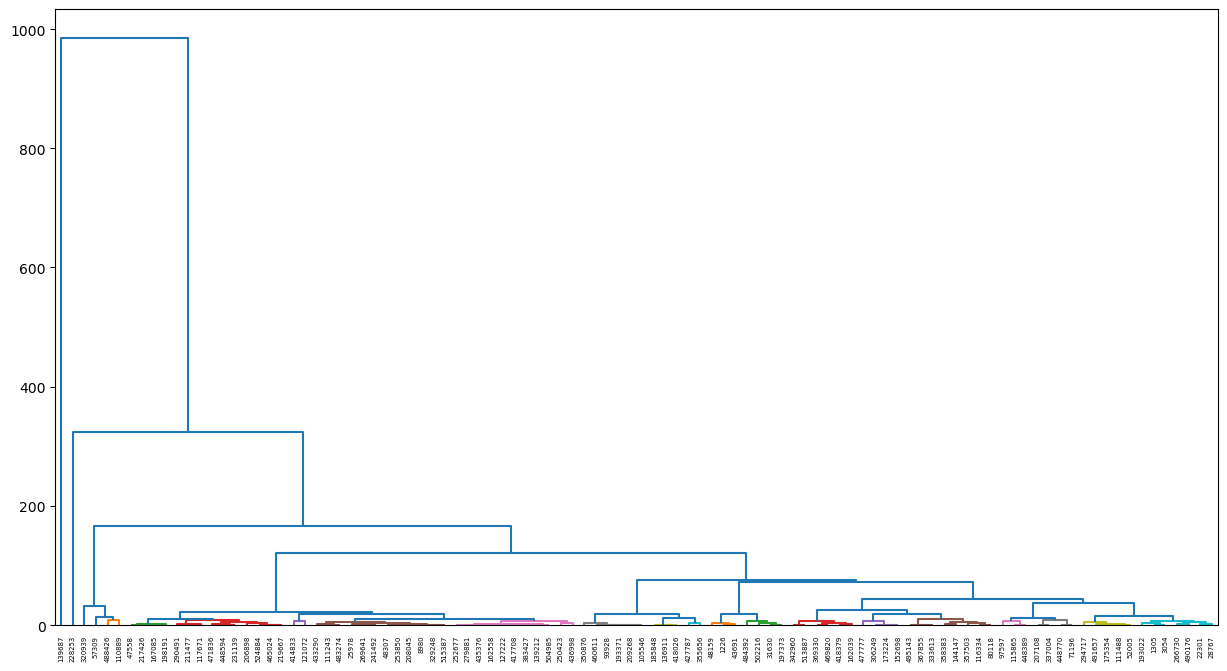

1      3
2      1
3     39
4     11
5      7
6     18
7      7
8     12
9      1
10     1
dtype: int64


In [41]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# A subset of columns for clustering
data = df[['Quantity', 'UnitPrice', 'MonetaryValue', 'Cluster']].sample(n=100, random_state=42)

# Performing hierarchical clustering
Z = linkage(data, method='ward', metric='euclidean')

# Selecting number of clusters
num_clusters = 10  

# Assigning cluster labels based on the number of clusters
clusters = fcluster(Z, num_clusters, criterion='maxclust')

# dendrogram plot with cluster colors
plt.figure(figsize=(15, 8))
dendrogram(Z, labels=data.index, leaf_rotation=90, color_threshold=num_clusters)
plt.show()

cluster_distribution = pd.Series(clusters).value_counts().sort_index()
print(cluster_distribution)